In [1]:
#Requires MCTS, POMDPs
#include(joinpath("MultiLanePOMDP","src","Multilane.jl"))
include(joinpath("..","src","Multilane.jl"))


Use "Dict(a=>b, ...)" instead.

Use "Dict(a=>b, ...)" instead.


isterminal (generic function with 5 methods)

In [2]:
#Set up problem configuration
nb_lanes = 2
pp = PhysicalParam(nb_lanes,lane_length=200.) #2.=>col_length=8
r_crash = -1.
accel_cost = -1e-5
decel_cost = -5e-6
invalid_cost = -1e-5
lineride_cost = -1e-5
lanechange_cost = -2e-5
_discount = 1.
pomdp = MLPOMDP(nb_cars=3,nb_lanes=nb_lanes,phys_param=pp,p_fail_enter=-0.01,
            r_crash=r_crash,accel_cost=accel_cost,decel_cost=decel_cost,
invalid_cost=invalid_cost,lineride_cost=lineride_cost,lanechange_cost=lanechange_cost,discount=_discount);

In [3]:
# initialize the solver
# the hyper parameters in MCTS can be tricky to set properly
# n_iterations: the number of iterations that each search runs for
# depth: the depth of the tree (how far away from the current state the algorithm explores)
# exploration constant: this is how much weight to put into exploratory actions. 
# A good rule of thumb is to set the exploration constant to what you expect the upper bound on your average 
#  expected reward to be.

solver = MCTSSolver(n_iterations=100, depth=10, exploration_constant=1.0)

# initialize the policy by passing in your problem and the solver
policy = MCTSPolicy(solver, pomdp);

In [4]:
rng = MersenneTwister(9) # initialize a random number generator
n_ep = 1
Rs = [Float64[] for _=1:n_ep]#zeros(n_ep)
nb_early_term = 0
histS = Array{MLState,1}[]
histA = Array{MLAction,1}[]
for j = 1:n_ep
    push!(histS,MLState[])
    push!(histA,MLAction[])
    s = init(pomdp,rng)
    rtot = 0.0
    disc = 1.0
    for i = 1:100
        # get the action from our SARSOP policy
        a = action(policy, s) # the QMDP action function returns the POMDP action not its index like the SARSOP action function
        #if j == n_ep
            push!(histS[j],s)
            push!(histA[j],a)
        #end
        # compute the reward
        r = reward(pomdp, s, a)
        push!(Rs[j],r)
        rtot += disc*r
        if isterminal(pomdp,s,a)
            nb_early_term += 1
            break
        end
        disc *= discount(pomdp)
        print("\rEp:$j, t=$i")
        # transition the system state
        """
        trans_dist = transition(mdp, s, a)
        rand(rng, trans_dist, s)
        """
        s = next(rng,pomdp,s,a)
    end
    #Rs[j] = rtot
    print("\rTotal discounted reward: $rtot")
end

Total discounted reward: -0.0009500000000000006

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"i",50,1:100,true)

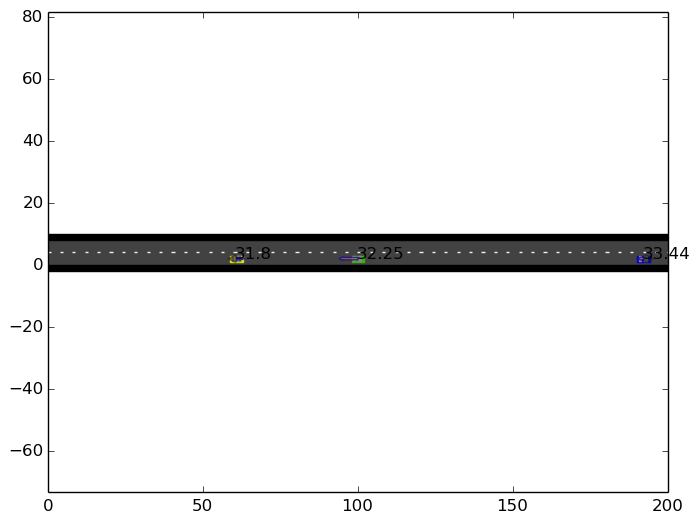

In [5]:
blas = 1
display_sim(pomdp,histS[blas],histA[blas])
#Warning! Only use if it crashes relatively early--unintelligible otherwise
#abs_display_sim(pomdp,histS[blas],histA[blas])

In [6]:
j = 52 #if there's early stopping, else j = n_ep
crash_rate = nb_early_term/j
println("$crash_rate +/- $(sqrt(crash_rate*(1.-crash_rate)/j))")
nb_early_term

0.0 +/- 0.0


0

In [7]:
#Calculate the total (discounted/undiscounted) cost, minus crashing
n_ep = 1
R_disc = zeros(n_ep)
R_MC = zeros(n_ep)
for (ep,R) in enumerate(Rs[1:n_ep])
    disc = 1.
    for i =1:length(R)-1
        r = R[i]
        R_disc[ep] += disc*r
        disc *= 0.99
        R_MC[ep] += r
    end
end

println((mean(R_MC),std(R_MC)))
println((mean(R_disc),std(R_disc)))
println(nb_early_term)
#ec=10:  ~30% crash, -0.08 reward
#ec=100: ~36% crash, -0.1578 reward
#ec=30: ~24.8% crash, -0.09 reward || 32.72% crash, -0.1467 reward (100 sim)
#ec=60: ~44% crash, -0.177 reward
###4 cars, 3 lanes: 41% crash rate, -0.126 reward

(-0.0009400000000000006,NaN)
(-0.000592785304385582,NaN)
0


In [9]:
#Tree visualization--does not work
#=
function MCTS.node_tag(s::MLState)
    return "[$(s.agent_pos),$(s.agent_vel)]"
end

MCTS.node_tag(a::MLAction) = "[$(a.vel),$(a.lane_change)]"
TreeVisualizer(policy, histS[450])
=#

In [12]:
#This stuff VVV is for dumping to a mp4 file--requires ffmpeg
# Didn't test
#=
using PyCall
@pyimport matplotlib.animation as anim
=#

In [11]:
# Didn't test
#=
X = reverse(histS)
Y = reverse(histA)
function func(x...)
    if length(X) < 1
        return
    end
    s = pop!(X)
    a = pop!(Y)
    visualize(pomdp,s,a)
end
=#

In [10]:
#= Didn't test
#=
fig = figure()
ani=anim.FuncAnimation(fig,func)
fname = "MCTS_3lane5car.mp4"

ani[:save](fname, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"]);

# # call our new function to display the animation
display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
base64encode(open(readbytes,fname)),"""" type="video/mp4"></video>"""));
=#

LoadError: LoadError: syntax: incomplete: unterminated multi-line comment #= ... =#
while loading In[10], in expression starting on line 12